### Risk Premia介绍

#### 原理：
配置各种类型的风险资产，并长期持有，挣取风险溢价。<br>

#### 例子：
比较出名的是之前出书<Principle>的Ray Dalio，他们的All Weather Portfolio就是这类型的搞法，<br>
当然不太清楚他们的具体仓位配置，但通过ETF可以配置出类似的效果：<br>
链接：http://www.lazyportfolioetf.com/allocation/ray-dalio-all-weather/<br>
配置：<br>
30%  VTI Vanguard Total Stock Market          美国蓝筹<br>
40%  TLT iShares 20+ Year Treasury Bond        美国长期国债<br>
15%  IEI iShares 3-7 Year Treasury Bond        美国中期国债<br>
7.5% GLD SPDR Gold Trust                  商品黄金<br>
7.5% GSG iShares S&P GSCI Commodity Indexed Trust 商品<br>
<br>
还有常Ivy Portfolio 青藤投资组合<br>
链接：http://www.lazyportfolioetf.com/allocation/mebane-faber-ivy/<br>
配置：<br>
20%  VTI Vanguard Total Stock Market          美国蓝筹<br>
20%  VEU Vanguard FTSE All-World ex-US         富时全球蓝筹股票（除美国）<br>
20%  VNQ Vanguard Real Estate               美国地产<br>
20%  BND Vanguard Total Bond Market           美国国债全周期组合<br>
20%  GSG iShares S&P GSCI Commodity Indexed Trust 商品<br>
<br>
还有很多...<br>

### 导入包

In [1]:
from __init__ import *
import time
import pandas as pd
import numpy as np
from helper import *
import matplotlib.pyplot as plt
%matplotlib inline

### 下载数据

In [2]:
custom_list = ["VTI", "TLT", "GLD"] # 这个组合是 美国蓝筹 美国长期国债 黄金

allweather_list = ["VTI", "TLT", "IEI", "GLD", "GSG"] # 桥水all weather组合
allweather_weight = pd.Series(index=allweather_list, data=[0.3, 0.4, 0.15, 0.075, 0.075])

ivy_list = ["VTI", "VEU", "VNQ", "BND", "GSG"] # 常青藤组合
ivy_weight = pd.Series(index=ivy_list, data=[0.2, 0.2, 0.2, 0.2, 0.2])

symbol_list = list(set(custom_list+allweather_list+ivy_list))+["GOVT", "GBTC"]

symbol_list = custom_list

In [ ]:
# AVApiKey = "AJ198CR6UF1FAEF4"
# for symbol in symbol_list:
#     print(symbol, end=" ")
#     data = pd.read_csv("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+symbol+"&apikey="+AVApiKey+"&datatype=csv&outputsize=full")
#     data = data.iloc[::-1].reset_index(drop=True)
#     data.to_csv("./data/"+symbol+".csv", index=False)
#     time.sleep(12)

### 加载数据

In [3]:
portfolio_price = None
for symbol in symbol_list:
    print(symbol, end=" ")
    tmp_data = pd.read_csv("./data/%s.csv"%symbol)
    tmp_data["date"] = pd.to_datetime(tmp_data["timestamp"])
    tmp_data[symbol] = tmp_data["adjusted_close"]
    tmp_data.set_index("date", inplace=True)
    if portfolio_price is None:
        portfolio_price = tmp_data[symbol].copy()
    else:
        portfolio_price = pd.merge(portfolio_price, tmp_data[symbol].copy(), how="outer", on="date")
        
portfolio_price.dropna(inplace=True) # 资产调整价格

VTI TLT GLD 

In [4]:
portfolio_return = portfolio_price.pct_change().fillna(0) # 资产每日收益率

### Plot价格与收益率 感受下不同标的10年来的走势

#### Plot 价格

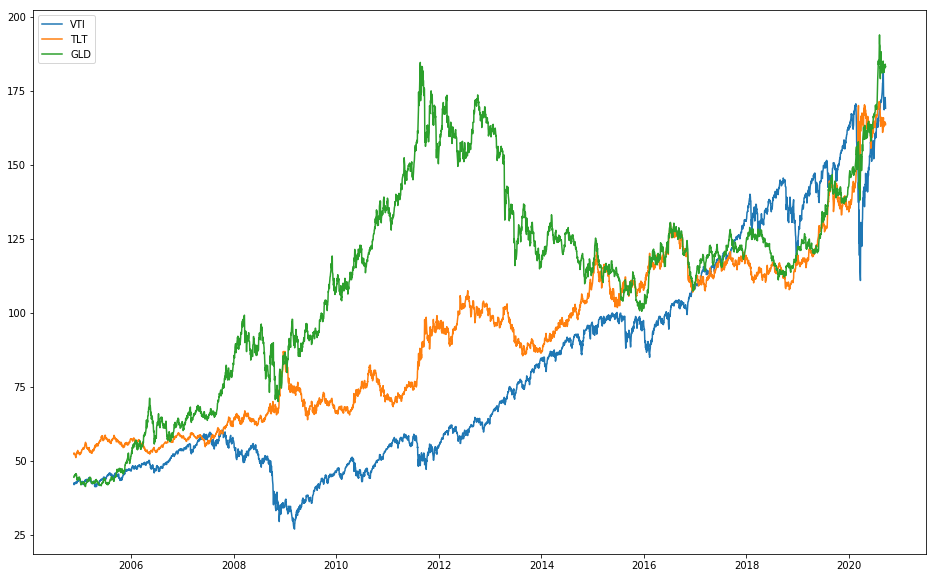

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(1, figsize=(16, 10))
for symbol in symbol_list:
    plt.plot(portfolio_price[symbol].index, portfolio_price[symbol].values, label=symbol)
plt.legend(loc="upper left");

#### Plot 累计收益率

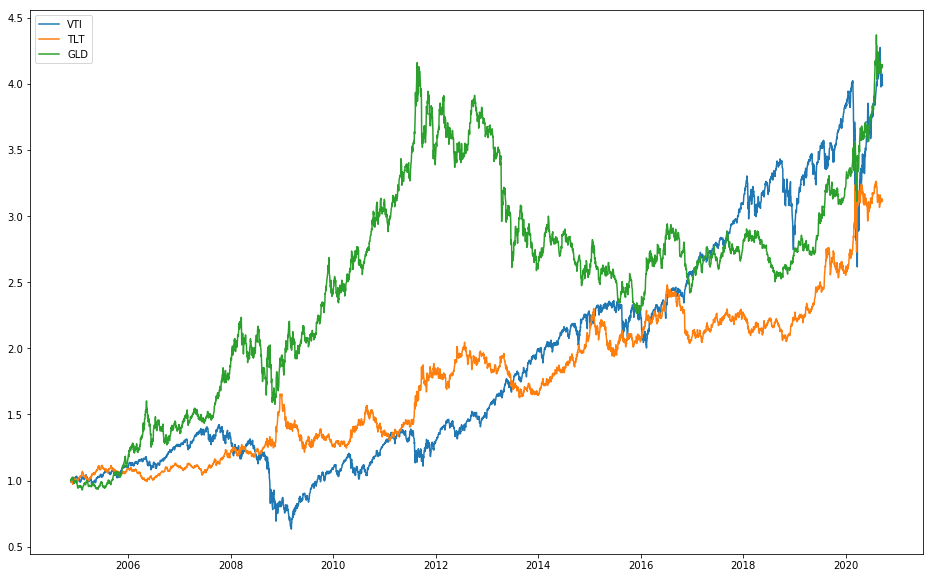

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(1, figsize=(16, 10))
for symbol in symbol_list:
    plt.plot(portfolio_return[symbol].index, (portfolio_return[symbol]+1).cumprod(), label=symbol)
plt.legend(loc="upper left");

### 各种组合对比

In [7]:
# 桥水原版
allweather_return = portfolio_return.loc[:, allweather_list] * allweather_weight

# 常青藤原版
ivy_return = portfolio_return.loc[:, ivy_list] * ivy_weight

# 桥水等权
allweather_ew_return = portfolio_return.loc[:, allweather_list]/len(allweather_list)



/home/pg_admin/miniconda3/envs/py37/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


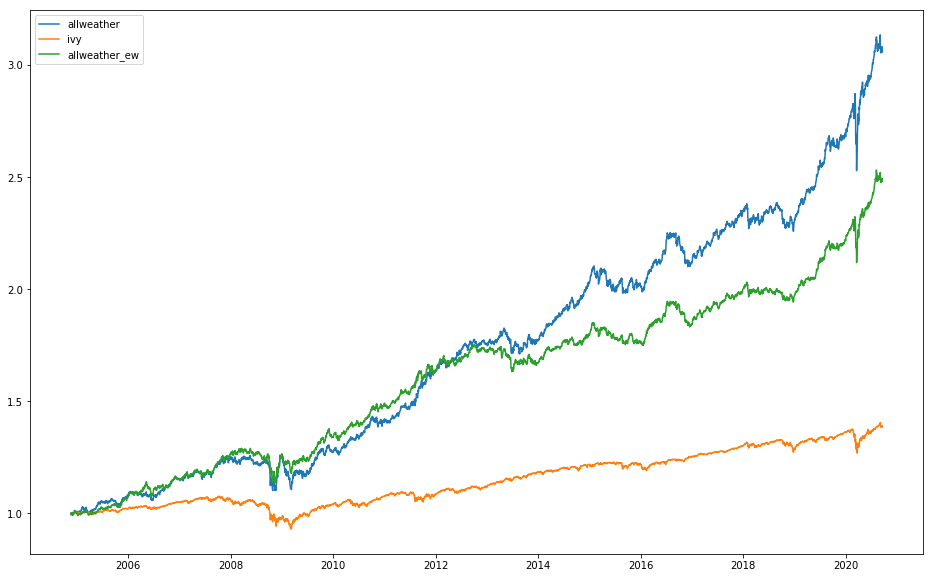

In [8]:
plt.figure(1, figsize=(16, 10))
plt.plot(allweather_return.index, (allweather_return.sum(axis=1)+1).cumprod(), label="allweather")
plt.plot(ivy_return.index, (ivy_return.sum(axis=1)+1).cumprod(), label="ivy")
plt.plot(allweather_ew_return.index, (allweather_ew_return.sum(axis=1)+1).cumprod(), label="allweather_ew")
plt.legend(loc="upper left");

### 风险平价

In [9]:
#selected_list = symbol_list
selected_list = ["VTI", "TLT", "GLD",]
#selected_list = allweather_list.copy()
selected_portfolio_return = portfolio_return.loc[:, selected_list]
selected_portfolio_price = portfolio_price.loc[:, selected_list]

In [20]:
initEq = 10000 # 初始资金
perShareComm = 0.005 # 美股每股手续费
minCommPerOrder = 1 # 最低手续费
rebalFrequency = 1 # 配平频率（单位月）
capFrequency = 1 # 利润再投频率（单位月）
#assetVolTarget = 0.2 # 波动率目标
portfolioVolTarget = 0.3 # 波动率目标
volLookback = 63 # 计算波动率的数据长度（单位日）
leverage = 1. # 杠杆（1就是无杠杆）

In [21]:
# 计算波动率
daily_vol = selected_portfolio_return.rolling(volLookback).std() * np.sqrt(252)

# 仓位系数，比如说：目标波动5%，5个标的物，每个标的波动率目标是1%，如果标的物波动是2%，那系数就是0.5，也就是用掉一半资金
daily_theosize = (portfolioVolTarget/len(selected_list)/ daily_vol).shift() # shift是因为调仓的时候，用的是上一日的close数据算出来的，调仓发生在今天
#daily_theosize = (assetVolTarget/ daily_vol).shift() # shift是因为调仓的时候，用的是上一日的close数据算出来的，调仓发生在今天

# 总杠杆率：各个标的的仓位系数加和，如果小于一，那就是各个标的波动率都挺大的，没用光现金就达到了目标波动
# 反之则是需要动用杠杆
totalsize = daily_theosize.sum(axis=1)

# 调整系数：防止资金配置超过杠杆率
daily_adjfactor = pd.Series(index=totalsize.index, data=np.where(totalsize>leverage, leverage/totalsize, 1.), name="adjfactor")

# 调整后仓位系数
daily_theosize_constrained = daily_theosize.multiply(daily_adjfactor, axis=0).dropna()

In [22]:
# 回测用价格序列
prices_df = pd.DataFrame(index=daily_theosize_constrained.index).join(selected_portfolio_price)

# 现金：初始的现金就是初始资金
cash = initEq
# 各标的物当前持仓
sharepos = np.repeat(0., len(selected_list))
# 各标的物波动率调整时的目标股数
targetshares = np.repeat(0., len(selected_list))
# 总权益
equity = initEq
# 用来做buying power的权益
capEquity = initEq

# 经过月数
month_counter = 0
pre_year = None
pre_month = None
is_month_change = True

# 回测结果：各类别标的持仓
volsize_rebal_shares = pd.DataFrame(index=prices_df.index, columns=selected_list+["Cash"], dtype=np.float64)
# 回测结果：各类别标的价值
volsize_rebal_exposure = pd.DataFrame(index=prices_df.index, columns=selected_list+["Cash"], dtype=np.float64)
# 回测结果：各类别标的手续费
volsize_rebal_commission = pd.DataFrame(index=prices_df.index, columns=selected_list+["Cash"], dtype=np.float64)

for i in range(len(prices_df)):
    # 当日标的收盘价
    currentprice = prices_df.iloc[i]
    # 当日标的理论配比
    currenttheosize = daily_theosize_constrained.iloc[i]
    
    # 当日总权益：每个标的物的 (股数 * 价格) 之和 再加上现金
    equity = np.sum(sharepos * currentprice) + cash
    
    # 当日日期
    date = currentprice.name
    year = date.year
    month = date.month
    if (year!=pre_year) or (month!=pre_month):
        month_counter = month_counter + 1
        is_month_change = True
    else:
        is_month_change = False
    pre_year = year
    pre_month = month
    
    # cash再投
    if capFrequency > 0:
        if is_month_change and ((month_counter-1)%capFrequency == 0):
            capEquity = equity
            
    # 根据波动率调整仓位
    if rebalFrequency > 0:
        if is_month_change and ((month_counter-1)%rebalFrequency == 0):
            targetshares = np.floor((capEquity*currenttheosize)/currentprice)
            
    
    # 目标仓位-当前仓位=需要交易的仓位
    trades = targetshares - sharepos
    # 交易额
    tradevalue = trades * currentprice
    # 手续费（美股按per share收的，A股这类按价值比例收的得改逻辑）
    commissions = trades.abs() * perShareComm
    # 最小手续费限制
    commissions[(commissions>0) & (commissions < minCommPerOrder)] = minCommPerOrder
    
    # 现金=之前现金-交易额-手续费
    cash = cash - tradevalue.sum() - commissions.sum()
    # 当前持仓=目标持仓
    sharepos = targetshares
    # 当时股票市值=持仓股数*现价
    sharevalue = sharepos * currentprice
    # 权益=组合总市值+现金
    equity = sharevalue.sum() + cash
    
    # 回测结果数据
    # 持仓明细
    volsize_rebal_shares.iloc[i] = sharepos.append(pd.Series(index=["Cash"], data=[0]))
    # 各资产价值
    volsize_rebal_exposure.iloc[i] = sharevalue.append(pd.Series(index=["Cash"], data=[cash]))
    # 手续费
    volsize_rebal_commission.iloc[i] = commissions.append(pd.Series(index=["Cash"], data=[0]))

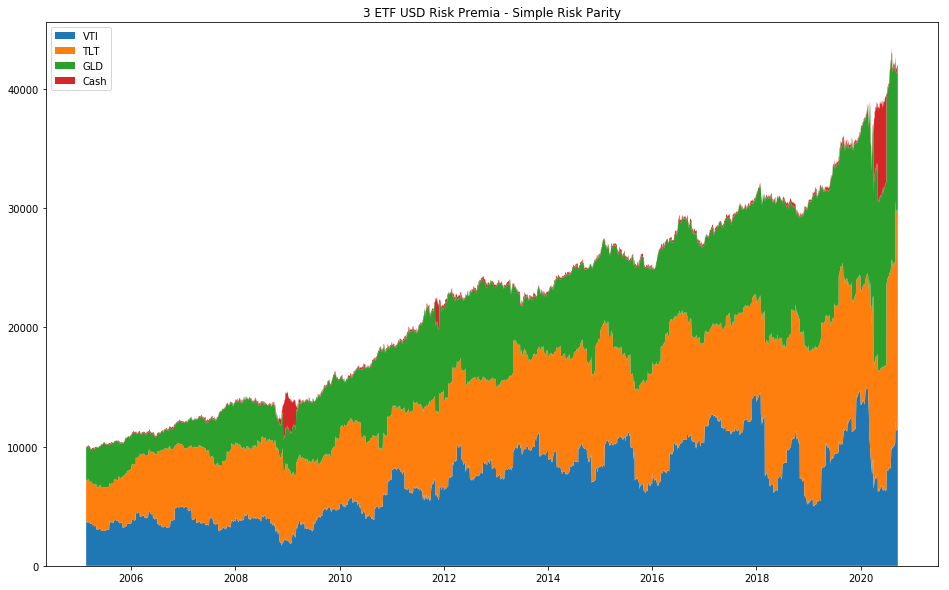

In [23]:
# Stacked area chart
plt.figure(1, figsize=(16, 10))
plt.title("%d ETF USD Risk Premia - Simple Risk Parity"%len(selected_list))
plt.stackplot(volsize_rebal_exposure.index, volsize_rebal_exposure.values.T, labels=list(volsize_rebal_exposure.columns))
plt.legend(loc="upper left");

In [24]:
# 绩效汇总
volsize_rebal_totalequity = volsize_rebal_exposure.sum(axis=1)
volsize_rebal_returns = (volsize_rebal_totalequity/ volsize_rebal_totalequity.shift() - 1).dropna()#fillna(0)
return_series = volsize_rebal_returns

AnnualizedReturn = ((return_series+1).cumprod().iloc[-1])**(1/(len(return_series)/252))-1
AnnualizedSharpe = zero_divide(np.mean(return_series)* np.sqrt(252), np.std(return_series, ddof=1))
AnnualizedVol = return_series.std() * np.sqrt(252)
print("AnnualizedReturn=", AnnualizedReturn)
print("AnnualizedSharpe=", AnnualizedSharpe)
print("AnnualizedVol=", AnnualizedVol)

AnnualizedReturn= 0.09611851657683679
AnnualizedSharpe= 1.1330831538584825
AnnualizedVol= 0.08413652694754489
